In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print(f"Comands: {commands}")

Comands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


MELANGEZ L'AUDIO

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(f'Nb examples: {num_samples}')
print(f"Nb examples per label: {len(tf.io.gfile.listdir(str(data_dir/commands[0])))}")
print(f'Example file tensor: {filenames[0]}')

Nb examples: 8000
Nb examples per label: 1000
Example file tensor: b'data/mini_speech_commands/yes/471a0925_nohash_1.wav'


### LIRE LES FICHIER AUDIO ET LEURS ETIQUETTES

In [7]:
test_file = tf.io.read_file(DATASET_PATH+'/yes/471a0925_nohash_1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

Prétraiter les fichiers audio WAV bruts de l'ensemble de données en tenseurs audio

In [8]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=1)

Créer des étiquettes à l'aide des répertoires parents pour chaque fichier

In [14]:
@tf.autograph.experimental.do_not_convert
def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform,label

### DATA PREPROCESSING

In [12]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]
print(f'Train: {len(train_files)}')
print(f'Val: {len(val_files)}')
print(f'Test: {len(test_files)}')

Train: 6400
Val: 800
Test: 800


Créer l'ensemble d'entraînement pour extraire les paires d'étiquettes audio

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

### TRACER QUELQUES FORMES D'ONDE

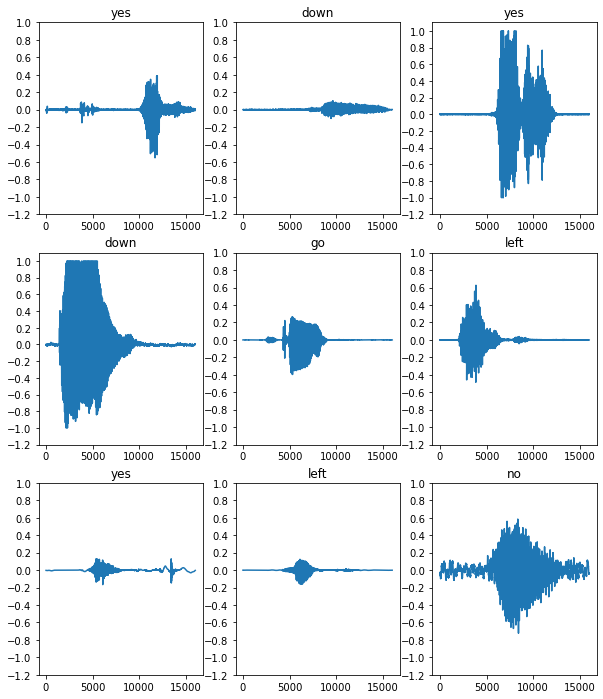

In [16]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

### CONVERTIR DES FORMES D'ONDE EN SPECTOGRAMMES

In [85]:
 @tf.autograph.experimental.do_not_convert
def get_spectrogram(waveform):
    # REMPLIR LES CLIPS AUDIO QUI DIRENT MOINS D'UNE SECONDE PAR 0
    input_len = 1600
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32
    )
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    # CONVERT THE WAVEFORM TO A SPECTROGRAM
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

EXPLORATION DES DONNEES

In [68]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
print(f'Label: {label}')
print(f'Waveform shape: {waveform.shape}')
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Audio playback


In [79]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')

TRACER LA FORME D'ONDE ET LE SPECTROGRAMME CORRESPONDANT

(0.0, 16000.0)

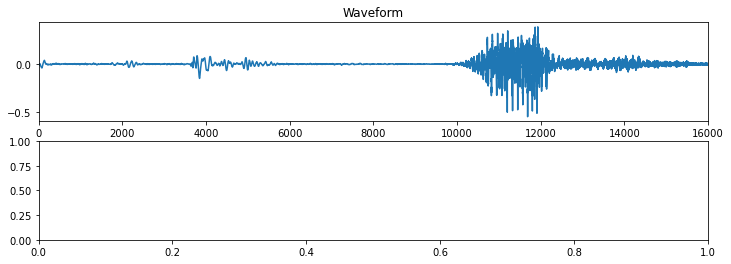

In [81]:
fig, axes = plt.subplots(2, figsize=(12, 4))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

# plot_spectrogram(spectrogram.numpy(), axes[1])
# axes[1].set_title('Spectrogram')
# plt.show()

TRANSFORMER L'ENSEMBLE DE DONNEES EN FORME D'ONDE EN SPECTROGRAMMES

In [83]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [88]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
spectrogram_ds

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.complex64, tf.int64)>

### CONSTRUIRE ET ENTRAINER LE MODELE

In [92]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE
    )
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE
    )
    return output_ds

In [93]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Regrouper les ensembles d'entraînement et de validation pour l'entraînement du modèle

In [94]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Réduire la latence de lecture lors de l'entraînement du modèle

In [95]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [96]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print(f"Input shape: {input_shape}")

Input shape: (124, 129, 1)


In [ ]:
num_labels = len(commands)
norm_layer = layers.experimental.preprocessing.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])
model.summary()

/home/kiad/.local/lib/python3.8/site-packages/numpy/core/_methods.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/kiad/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
